# Testing TensorFlow Lite models

This notebooks shows some ways for debugging TensorFlow Lite models and comparing them with the original implementations in TensorFlow.

For more details, take a look at blog posts:

- [Testing TensorFlow Lite image classification model](https://thinkmobile.dev/testing-tensorflow-lite-image-classification-model/) - converting TensorFlow to TensorFlow Lite and comparing models side by side.
- [Automate testing of TensorFlow Lite model implementation](https://thinkmobile.dev/automate-testing-of-tensorflow-lite-model-implementation/) - Testing TensorFlow Lite model on Android app with Espresso and instrumented tests.

### How accurate is this notebook?

It's worth to mention, that this notebook shows just some basic ideas for eye-comparison between TensorFlow and TensorFlow Lite models. It doesn't check them for speed and any other factor of performance and doesn't do any accurate side-by-side comparison. But still can be helpful with answering the question "why a model implemented on the app doesn't work the same like on notebook?".

## TensorFlow>= 2.0 and Colaboratory

This notebook can be executed in Colaboratory. It requires some changes to make it working on Docker environment described in linked blog post.

Examples presented in this notebook are built on top of TensorFlow>= 2.0 stable version.

### GPU support
The good thing about Colab is that it supports GPU envinronment without additional work. Just open **Runtime -> Change runtime type** and make sure that GPU is selected. The training process of this notebook should be about 3 times faster than on CPU env.

In [1]:
!pip install tensorflow-gpu
!pip install tensorflow_hub

     |████████████████████████████████| 394.3MB 41kB/s 


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

For better data visualization we'll use [Pandas library](https://pandas.pydata.org/).

In [3]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [4]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.4.1
Hub version:  0.11.0
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


In [5]:
#Next, connect to your Google drive to look at the model sizes
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/Colab Notebooks/Week11')
!ls

'4B_Training_testing_TFLite models.ipynb'   TFLite_Week2_Exercise.ipynb
 TFLite_Week1_Exercise.ipynb


## Simple transfer learning
For the sake of the notebook completness, we will do simple transfer learning, to create our own machine learning model. 

If you want to know more about it, I highly recommend to check Udacity ["Tensorflow free course"](https://classroom.udacity.com/courses/ud187), where the inspiration for transfer learning code came from.

### Task 1: Dataset preparation

 For this example you will use the TensorFlow flowers dataset.

In [8]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 1s 0us/step


In [9]:
# Create data generator for training and validation

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [10]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [11]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Daisy' 'Dandelion' 'Roses' 'Sunflowers' 'Tulips']


### Task 2: Model architecture, training

As a base model for transfer learning, we'll use MobileNet v2 model stored on TensorFlow Hub. Presented model can be used only in TensorFlow 2.0 implementation (TF Hub contains also models for TensorFlow 1.x).

Basic information about feature vector:
- Input shape: 224x224x3 (224x224 pixels, 3 chanels each, RGB format),
- Each channel has value in range [0, 1],
- Feature vector output shape: 1280 (number of labels classified by MobileNet is 1001 - this info isn't important here)

For more details check feature vector page:
https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4

In [12]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [14]:
# Run model training

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=10,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/10
92/92 [==============================] - 121s 1s/step - loss: 1.3230 - acc: 0.5229 - val_loss: 0.4867 - val_acc: 0.8331
Epoch 2/10
92/92 [==============================] - 117s 1s/step - loss: 0.4746 - acc: 0.8297 - val_loss: 0.4035 - val_acc: 0.8605
Epoch 3/10
92/92 [==============================] - 116s 1s/step - loss: 0.3754 - acc: 0.8620 - val_loss: 0.3718 - val_acc: 0.8632
Epoch 4/10
92/92 [==============================] - 118s 1s/step - loss: 0.3390 - acc: 0.8818 - val_loss: 0.3475 - val_acc: 0.8769
Epoch 5/10
92/92 [==============================] - 118s 1s/step - loss: 0.2900 - acc: 0.8984 - val_loss: 0.3578 - val_acc: 0.8700
Epoch 6/10
92/92 [==============================] - 119s 1s/step - loss: 0.2613 - acc: 0.9021 - val_loss: 0.3302 - val_acc: 0.8824
Epoch 7/10
92/92 [==============================] - 116s 1s/step - loss: 0.2555 - acc: 0.9151 - val_loss: 0.3519 - val_acc: 0.8714
Epoch 8/10
92/92 [==============================] - 116s 1s/step - loss: 0.2590 - a

In [15]:
# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)

23/23 [==============================] - 23s 1s/step - loss: 0.3341 - acc: 0.8865


In [16]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.33
Final accuracy: 88.65%


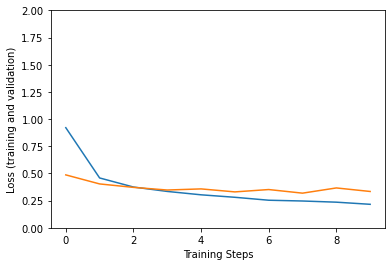

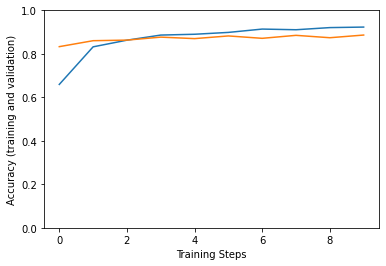

In [17]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

### Export your model

We'll save our model as TensorFlow SavedModel format. After that we'll do inference on reloaded model, so if you come with a model already trained, it'll be easier to inspect it.

In [ ]:
FLOWERS_SAVED_MODEL = "flowers_example"
tf.saved_model.save(model, FLOWERS_SAVED_MODEL)
print("TF model and their sizes:")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: flowers_example/assets


INFO:tensorflow:Assets written to: flowers_example/assets


TF model and their sizes:


## Verify that the model has been save in your google drive!

### Load TensorFlow SavedModel

Let's load TensorFlow model from SavedModel format. Because we used custom layer from TensorFlow Hub, we need to explicitly point out the implementation with `custom_obiects` param.

In [ ]:
# Load SavedModel

flowers_model = hub.load(FLOWERS_SAVED_MODEL)
print(flowers_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f2ee36d02e8>


### Task 3: Test predictions from the Tensorflow Model


In [ ]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
#Get quantitative performanve of the model
results = model.evaluate(val_image_batch, val_label_batch, batch_size=32)
print("Validation Loss,  acc:", results)

32/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 1s 18ms/sample - loss: 0.4919 

Validation batch shape tells us that we have a batch of 32 images, with size and channels: 224x224x3.

Let's calculate predictions for the entire batch and evaluate the model, qualitatively and quantitatively!

In [ ]:
tf_model_predictions = flowers_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 5)


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Tensorflow model Prediction results:")
tf_pred_dataframe.head()

Tensorflow model Prediction results:


,Daisy,Dandelion,Roses,Sunflowers,Tulips
0,0.00001822,0.00000403,0.97804660,0.00000293,0.02192821
1,0.02588960,0.00294554,0.00114363,0.96809435,0.00192683
2,0.05838386,0.00578586,0.00015546,0.93545192,0.00022295
3,0.01312715,0.00159383,0.00019425,0.98492742,0.00015740
4,0.00041054,0.00000955,0.63348854,0.07517079,0.29092053


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

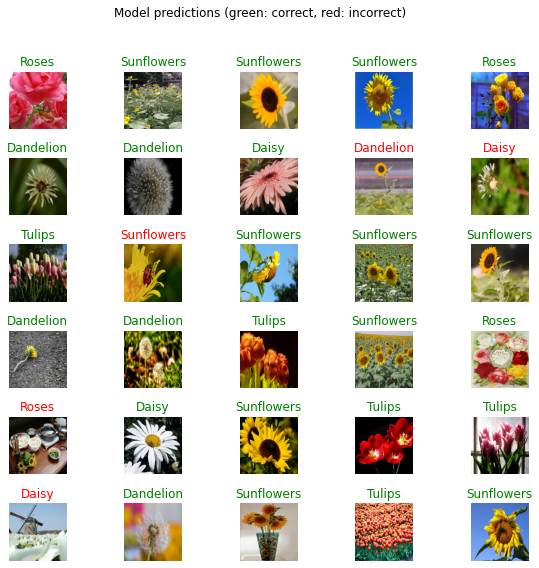

In [ ]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

### Task 4: Convert Tensorflow model to TFLite

Convert recently loaded model to TensorFlow Lite models (standard and quantized with a [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization)).


In [ ]:
!mkdir "tflite_models"

mkdir: cannot create directory ‘tflite_models’: File exists


In [ ]:
TFLITE_MODEL = "tflite_models/flowers.tflite"
TFLITE_QUANT_MODEL = "tflite_models/flowers_quant.tflite"

In [ ]:
# Get the concrete function from the Keras model.
# Convert the model, no quantization
converter = tf.lite.TFLiteConverter.from_saved_model(FLOWERS_SAVED_MODEL)
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_saved_model(FLOWERS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh

TFLite models and their sizes:
total 11M
-rw------- 1 root root 2.3M Jan 21 22:04 flowers_quant.tflite
-rw------- 1 root root 8.5M Jan 21 22:04 flowers.tflite


### TF Lite model Interpreter

Load TensorFlow lite model with interpreter interface.

In [ ]:
# Load TFLite model and see some details about input/output

tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: input_1
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [1 5]
type: <class 'numpy.float32'>


#### Resize input and output tensors shapes

Input shape of loaded TFLite model is 1x224x224x3, what means that we can make predictions for single image.

Let's resize input and output tensors, so we can make predictions for batch of 32 images.

In [ ]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: input_1
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [32  5]
type: <class 'numpy.float32'>


In [ ]:
tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (32, 5)


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe.columns = dataset_labels

print("TFLite prediction results for the first elements")
tflite_pred_dataframe.head()

TFLite prediction results for the first elements


,Daisy,Dandelion,Roses,Sunflowers,Tulips
0,0.00001822,0.00000403,0.97804672,0.00000293,0.02192813
1,0.02588991,0.00294557,0.00114364,0.96809411,0.00192684
2,0.05838322,0.00578580,0.00015546,0.93545252,0.00022295
3,0.01312703,0.00159382,0.00019425,0.98492742,0.00015740
4,0.00041054,0.00000955,0.63349003,0.07517076,0.29091913


Now let's do the same for TFLite quantized model:
- Load model,
- Reshape input to handle batch of images,
- Run prediction

In [ ]:
# Load quantized TFLite model
tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_QUANT_MODEL)

# Learn about its input and output details
input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

# Resize input and output tensors to handle batch of 32 images
tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

# Run inference
tflite_interpreter_quant.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter_quant.invoke()

tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
print("\nPrediction results shape:", tflite_q_model_predictions.shape)

== Input details ==
name: input_1
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [32  5]
type: <class 'numpy.float32'>

Prediction results shape: (32, 5)


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_q_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)
tflite_q_pred_dataframe.columns = dataset_labels

print("Quantized TFLite model prediction results for the first elements")
tflite_q_pred_dataframe.head()

Quantized TFLite model prediction results for the first elements


,Daisy,Dandelion,Roses,Sunflowers,Tulips
0,0.00000008,0.00000002,0.99986780,0.00000004,0.00013204
1,0.53954291,0.32092410,0.00815060,0.10747182,0.02391059
2,0.00136465,0.00916065,0.00019485,0.98927337,0.00000648
3,0.05502460,0.01071258,0.00065460,0.93288302,0.00072524
4,0.00001143,0.00002814,0.98112386,0.01715048,0.00168614


## Task 5: Compare prediction results

Now we will use Pandas to visualize results from all 3 models and find differences between them.

In [ ]:
# Concatenate results from all models

all_models_dataframe = pd.concat([tf_pred_dataframe, 
                                  tflite_pred_dataframe, 
                                  tflite_q_pred_dataframe], 
                                 keys=['TF Model', 'TFLite', 'TFLite quantized'],
                                 axis='columns')
all_models_dataframe.head()

TF Model                          ... TFLite quantized                        
        Daisy   Dandelion       Roses  ...            Roses  Sunflowers      Tulips
0  0.00001822  0.00000403  0.97804660  ...       0.99986780  0.00000004  0.00013204
1  0.02588960  0.00294554  0.00114363  ...       0.00815060  0.10747182  0.02391059
2  0.05838386  0.00578586  0.00015546  ...       0.00019485  0.98927337  0.00000648
3  0.01312715  0.00159383  0.00019425  ...       0.00065460  0.93288302  0.00072524
4  0.00041054  0.00000955  0.63348854  ...       0.98112386  0.01715048  0.00168614

[5 rows x 15 columns]

In [ ]:
#Lets look at the predicted outcomes first, then we will look at the individual scores.
#We have already computed predicted_ids, predicted_labels
tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)


tflite_q_predicted_ids = np.argmax(tflite_q_model_predictions, axis=-1)
tflite_q_predicted_labels = dataset_labels[tflite_q_predicted_ids]
tflite_q_label_id = np.argmax(val_label_batch, axis=-1)

In [ ]:
a=np.expand_dims(predicted_ids, axis=1)
b=np.expand_dims(tflite_label_id, axis=1)
c=np.expand_dims(tflite_q_label_id,axis=1)
d=np.expand_dims(true_label_ids,axis=1)
predictions_data=np.concatenate([a,b,c,d], axis=1)
#Last column is the actual result
print("TF, TFLite, TFLiteQ, Act\n")
print(predictions_data)

TF, TFLite, TFLiteQ, Act

[[2 2 2 2]
 [3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]
 [2 2 2 2]
 [1 1 1 1]
 [1 1 1 1]
 [0 0 0 0]
 [1 3 3 3]
 [0 1 1 1]
 [4 4 4 4]
 [3 1 1 1]
 [3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]
 [1 1 1 1]
 [1 1 1 1]
 [4 4 4 4]
 [3 3 3 3]
 [2 2 2 2]
 [2 3 3 3]
 [0 0 0 0]
 [3 3 3 3]
 [4 4 4 4]
 [4 4 4 4]
 [0 4 4 4]
 [1 1 1 1]
 [3 3 3 3]
 [4 4 4 4]
 [3 3 3 3]
 [1 1 1 1]
 [4 4 4 4]]


In [ ]:
#Next, lets look at the quantized scores to be specific
# Swap columns to hava side by side comparison

all_models_dataframe = all_models_dataframe.swaplevel(axis='columns')[tflite_pred_dataframe.columns]
all_models_dataframe.head()

Daisy              ...      Tulips                 
     TF Model      TFLite  ...      TFLite TFLite quantized
0  0.00001822  0.00001822  ...  0.02192813       0.00013204
1  0.02588960  0.02588991  ...  0.00192684       0.02391059
2  0.05838386  0.05838322  ...  0.00022295       0.00000648
3  0.01312715  0.01312703  ...  0.00015740       0.00072524
4  0.00041054  0.00041054  ...  0.29091913       0.00168614

[5 rows x 15 columns]

In [ ]:
# Highlight TFLite models predictions that are different from original model

def highlight_diff(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    other = data.xs('TF Model', axis='columns', level=-1)
    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                        index=data.index, columns=data.columns)

all_models_dataframe.style.apply(highlight_diff, axis=None)

As we can see, in most cases predictions are different between all models, usually by small factors. High-confidence predictions between TensorFlow and TensorFlow Lite models are very close to each other (in some cases there are even similar).  
Quantized model outstands the most, but this is the cost of optimizations (model weights 3-4 times less).

To make prediction results even more readable, let's simplify dataframes, to show only the highest-score prediction and the corresponding label.

In [ ]:
# Concatenation of argmax and max value for each row
def max_values_only(data):
  argmax_col = np.argmax(data, axis=1).reshape(-1, 1)
  max_col = np.max(data, axis=1).reshape(-1, 1)
  return np.concatenate([argmax_col, max_col], axis=1)

# Build simplified prediction tables
tf_model_pred_simplified = max_values_only(tf_model_predictions)
tflite_model_pred_simplified = max_values_only(tflite_model_predictions)
tflite_q_model_pred_simplified = max_values_only(tflite_q_model_predictions)

In [ ]:
# Build DataFrames and present example
columns_names = ["Label_id", "Confidence"]
tf_model_simple_dataframe = pd.DataFrame(tf_model_pred_simplified)
tf_model_simple_dataframe.columns = columns_names

act_model_simple_dataframe = pd.DataFrame(true_label_ids)
act_model_simple_dataframe.columns = ["Actual"]

tflite_model_simple_dataframe = pd.DataFrame(tflite_model_pred_simplified)
tflite_model_simple_dataframe.columns = columns_names

tflite_q_model_simple_dataframe = pd.DataFrame(tflite_q_model_pred_simplified)
tflite_q_model_simple_dataframe.columns = columns_names

tf_model_simple_dataframe.head()

,Label_id,Confidence
0,2.0,0.97804660
1,3.0,0.96809435
2,3.0,0.93545192
3,3.0,0.98492742
4,2.0,0.63348854


In [ ]:
# Concatenate results from all models
all_models_simple_dataframe = pd.concat([tf_model_simple_dataframe, 
                                         tflite_model_simple_dataframe, 
                                         tflite_q_model_simple_dataframe,
                                         act_model_simple_dataframe], 
                                        keys=['TF Model', 'TFLite', 'TFLite quantized','Actual'],
                                        axis='columns')

print(all_models_simple_dataframe.iloc[:32,:])


   TF Model               TFLite  ... TFLite quantized             Actual
   Label_id  Confidence Label_id  ...         Label_id  Confidence Actual
0       2.0  0.97804660      2.0  ...              2.0  0.99986780      2
1       3.0  0.96809435      3.0  ...              0.0  0.53954291      3
2       3.0  0.93545192      3.0  ...              3.0  0.98927337      3
3       3.0  0.98492742      3.0  ...              3.0  0.93288302      3
4       2.0  0.63348854      2.0  ...              2.0  0.98112386      2
5       1.0  0.98486173      1.0  ...              1.0  0.99033469      1
6       1.0  0.99960393      1.0  ...              1.0  0.99999619      1
7       0.0  0.95253044      0.0  ...              1.0  0.81351668      0
8       1.0  0.65503299      1.0  ...              0.0  0.37377650      3
9       0.0  0.69783032      0.0  ...              1.0  0.73067361      1
10      4.0  0.99652416      4.0  ...              4.0  0.97665340      4
11      3.0  0.47550353      3.0  ... 

In [ ]:
# Swap columns for side-by-side comparison
all_models_simple_dataframe = all_models_simple_dataframe.swaplevel(axis='columns')[tf_model_simple_dataframe.columns]
# Highlight differences
all_models_simple_dataframe.style.apply(highlight_diff, axis=None)

## Visualize predictions from TFLite models

At the end let's visualize predictions from TensorFlow Lite and quantized TensorFlow Lite models.

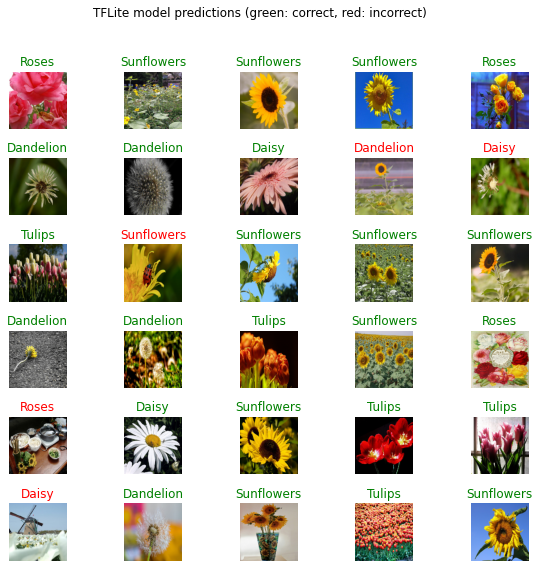

In [ ]:
# Print images batch and labels predictions for TFLite Model


plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("TFLite model predictions (green: correct, red: incorrect)")

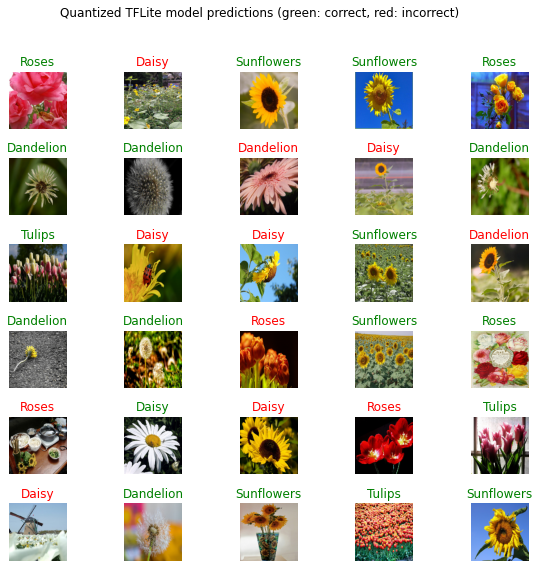

In [ ]:
# Print images batch and labels predictions for TFLite Model



plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_q_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_q_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Quantized TFLite model predictions (green: correct, red: incorrect)")